In [1]:
import numpy as np
import pandas as pd

In [2]:
import geopandas as gpd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

C:\Users\ibuce\AppData\Local\Temp\ipykernel_22940\2373738723.py:1: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [ ]:
import geoplot as gplt
import geoplot.crs as gcrs

In [89]:
# import and read data
export_data = pd.read_csv("export_codes.csv")
export_data.head()

,PRODUCT (Codes),00,01,02,03,04,05,06,07,08,...,90,91,92,93,94,95,96,97,99,TOTAL
0,AD,:,:,:,:,:,:,:,:,:,...,:,:,:,:,:,"51,759",:,:,:,"258,343"
1,AE,:,"89,550",:,:,"34,269",:,:,:,"76,050",...,"3,147,965","2,091",:,"82,750","5,262,324","5,409,431","1,131,828","5,104","20,190","185,936,042"
2,AF,:,:,:,:,:,:,:,:,:,...,"1,618",132,:,:,:,:,:,:,:,"1,400,330"
3,AG,:,:,:,:,:,:,:,:,:,...,:,:,:,:,:,"2,049",:,:,:,"10,045"
4,AI,:,:,:,:,:,:,:,:,:,...,"4,195",:,:,:,:,:,:,:,:,"4,195"


#### Clean data and handle missing values

In [136]:
# rename country column
export_data = export_data.rename(columns={'PRODUCT (Codes)': 'Country'})

# replace commas with empty strings 
export_data = export_data.replace(",", "", regex=True)

# handle missing values
export_data = export_data.replace(":", np.nan)
export_data = export_data.replace(np.nan, 0)

# convert to float
export_data.iloc[:, 1:] = export_data.iloc[:, 1:].applymap(lambda x: pd.to_numeric(x, errors="coerce"))
export_data.head()

,Country,00,01,02,03,04,05,06,07,08,...,90,91,92,93,94,95,96,97,99,TOTAL
0,AD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,51759.0,0.0,0.0,0.0,258343.0
1,AE,0.0,89550.0,0.0,0.0,34269.0,0.0,0.0,0.0,76050.0,...,3147965.0,2091.0,0.0,82750.0,5262324.0,5409431.0,1131828.0,5104.0,20190.0,185936042.0
2,AF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1618.0,132.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1400330.0
3,AG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2049.0,0.0,0.0,0.0,10045.0
4,AI,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4195.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4195.0


In [ ]:
# read dataset with country geometries
countries = gpd.read_file("C:/Users/ibuce/Downloads/world-administrative-boundaries.zip")
countries.plot()

In [118]:
print(len(countries))
countries.columns
countries.head()

256


,iso3,status,color_code,name,continent,region,iso_3166_1_,french_shor,geometry
0,NaN,Adm. by EGY,EGY,Ma'tan al-Sarra,Africa,Northern Africa,NaN,Ma'tan al-Sarra,"POLYGON ((33.25104 21.99977, 34.15064 21.99603..."
1,CHE,Member State,CHE,Switzerland,Europe,Western Europe,CH,Suisse,"POLYGON ((9.56672 47.54045, 9.55980 47.50209, ..."
2,NaN,UK Territory,GBR,Jersey,Europe,Northern Europe,NaN,Jersey,"POLYGON ((-2.01500 49.21417, -2.02111 49.17721..."
3,AUT,Member State,AUT,Austria,Europe,Western Europe,AT,Autriche,"POLYGON ((16.94618 48.61907, 16.94333 48.57333..."
4,PRT,Member State,PRT,Portugal,Europe,Southern Europe,PT,Portugal,"POLYGON ((-7.43185 37.25319, -7.41903 37.18055..."


In [147]:
# select only relevant columns
countries_df = countries[["iso_3166_1_", "continent", "geometry"]]

In [148]:
# add geometry to trade data
trade_merged = pd.merge(export_data, countries_df, 
                        left_on="Country", right_on="iso_3166_1_", how="left")

In [121]:
trade_merged.columns

Index(['Country', '00', '01', '02', '03', '04', '05', '06', '07', '08',
       ...
       '92', '93', '94', '95', '96', '97', '99', 'TOTAL', 'iso_3166_1_',
       'geometry'],
      dtype='object', length=102)

In [149]:
# convert into geopandas dataframe
trade_gdf = gpd.GeoDataFrame(trade_merged, geometry="geometry")

# drop redundant column
trade_gdf = trade_gdf.drop("iso_3166_1_", axis=1)

#### Visualise most important export destinations

In [168]:
# exclude data for whole world
trade_gdf = trade_gdf[trade_gdf != "WORLD"]

# column for total export in milions
trade_gdf["Total(Mil)"] = trade_gdf["TOTAL"]/1000000
trade_gdf["Total(Mil)"] = trade_gdf["Total(Mil)"].astype(float)

# subset to keep only total export
total_exp = trade_gdf[["Country", "Total(Mil)", "geometry"]]

# top 20 export destinations
total_top20 = total_exp.nlargest(20, "Total(Mil)")
print(total_top20[["Country","Total(Mil)"]])

    Country    Total(Mil)
252     NaN  87868.110530
58       DE  19238.755997
56       CZ  10304.246143
175      PL   7423.878896
100      HU   6445.110906
76       FR   5716.101418
12       AT   4887.004630
109      IT   4122.750545
78       GB   3211.015777
241      US   2745.985555
47       CN   2184.276584
196      RO   2167.050422
69       ES   2022.392676
162      NL   1790.729495
197      RU   1343.971649
42       CH   1233.058729
203      SE   1212.088603
19       BE   1080.003958
238      UA    829.755180
206      SI    785.752285


TypeError: float() argument must be a string or a real number, not 'NoneType'

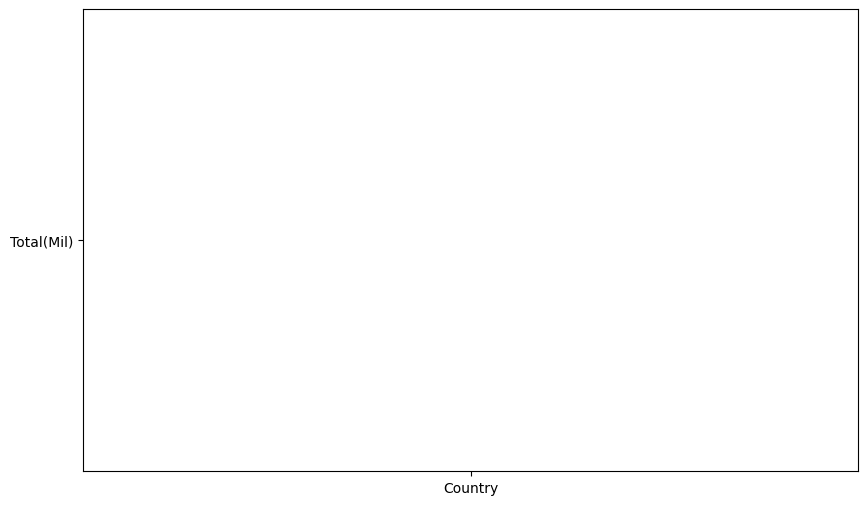

In [171]:
# create a plot for 20 largest importers of products from Slovakia
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar("Country" ,"Total(Mil)", total_top20, tick_label=total_top20['Country'])
ax.set_title("20 largest importers from Slovakia")
ax.set_xlabel('Country code')
ax.set_ylabel('Imports (millions)')

plt.show()

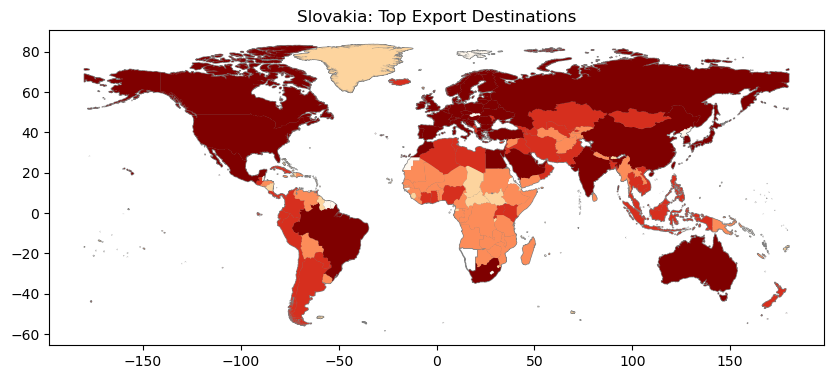

In [151]:
# visualize total export os Slovakia
fig, ax = plt.subplots(figsize=(10, 8))
countries_df.plot(ax=ax, facecolor='white', edgecolor='gray')
total_exp.plot(ax=ax, column='Total(Mil)', cmap='OrRd', scheme="quantiles")
ax.set_title('Slovakia: Top Export Destinations')
plt.show()

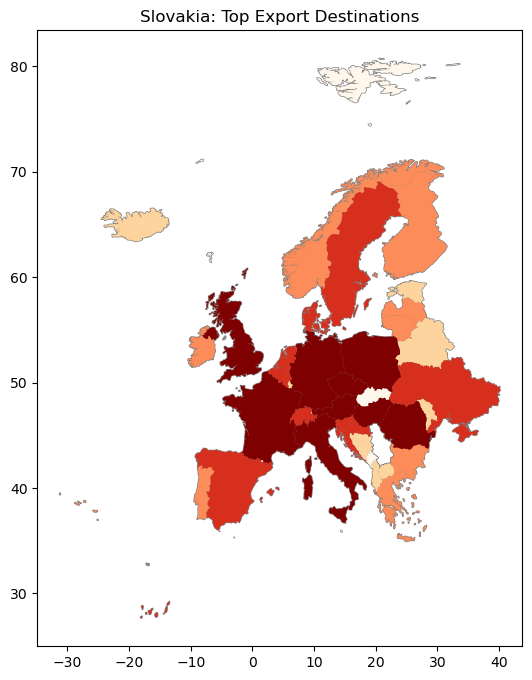

In [161]:
# only Europe
europe_exp = trade_gdf[trade_gdf["continent"] == "Europe"]
eu_exp_no_rus = europe_exp[europe_exp["Country"] != "RU"]

europe = countries_df[countries_df["continent"] == "Europe"]
eu_no_rus = europe[europe["iso_3166_1_"] != "RU"]

# visualize total export of Slovakia
fig, ax = plt.subplots(figsize=(10, 8))
eu_no_rus.plot(ax=ax, facecolor='white', edgecolor='gray')
eu_exp_no_rus.plot(ax=ax, column='Total(Mil)', cmap='OrRd', scheme="quantiles")
ax.set_title('Slovakia: Top Export Destinations in Europe')
plt.show()